In [41]:
import glob
import importlib
import sys, os

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u

import emcee

from dust_extinction.averages import G03_SMCBar
from dust_extinction.parameter_averages import F19

import measure_extinction
from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

Reload code for checks

In [73]:
importlib.reload(measure_extinction.modeldata)
importlib.reload(measure_extinction.stardata)
importlib.reload(measure_extinction)

<module 'measure_extinction' from '/Users/pyanchulova/Documents/ext-science/measure_extinction/__init__.py'>

In [2]:
m31_list = [
    "m31_e1_j004354.05+412626.0",
"m31_e2_j004413.84+414903.9",
"m31_e3_j004420.52+411751.1",
"m31_e4_j004427.47+415150.0",
# "m31_e5_j004431.66+413612.4",
# "m31_e6_j004438.71+415553.5",
# "m31_e7_j004454.37+412823.9",
# "m31_e8_j004511.82+415025.3",
# "m31_e9_j004511.85+413712.9",
# "m31_e10_j004512.73+413726.4",
# "m31_e11_j004535.40+414431.5",
# "m31_e12_j004539.00+415439.0",
# "m31_e13_j004539.70+415054.8",
# "m31_e14_j004543.46+414513.6",
# "m31_e15_j004546.81+415431.7",
]

Specify the location of the model and observed data

In [3]:
file_path = "/Users/pyanchulova/Documents/extstar_data/"
savefile_path = "/Users/pyanchulova/Documents/ext-science/figs/"

Define star specific parameters

In [4]:
# starname = "m31_e2_j004413.84+414903.9"
starname = m31_list[2]
print(starname)
fstarname = f"{starname}.dat"
velocity = -109.3 # M31 radial velocity from NED
relband = "ACS_F475W"

m31_e3_j004420.52+411751.1


Read in the star data

In [5]:
def get_red_star(fstarname, file_path):
    """
    """
    # get the observed reddened star data
    reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
    band_names = reddened_star.data["BAND"].get_band_names()
    data_names = reddened_star.data.keys()
    print("band names", band_names)
    print("data names", data_names)
    
    return reddened_star, band_names, data_names

### Plot offset spectra

m31_e13_j004539.70+415054.8
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
m31_e14_j004543.46+414513.6
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
m31_e15_j004546.81+415431.7
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])


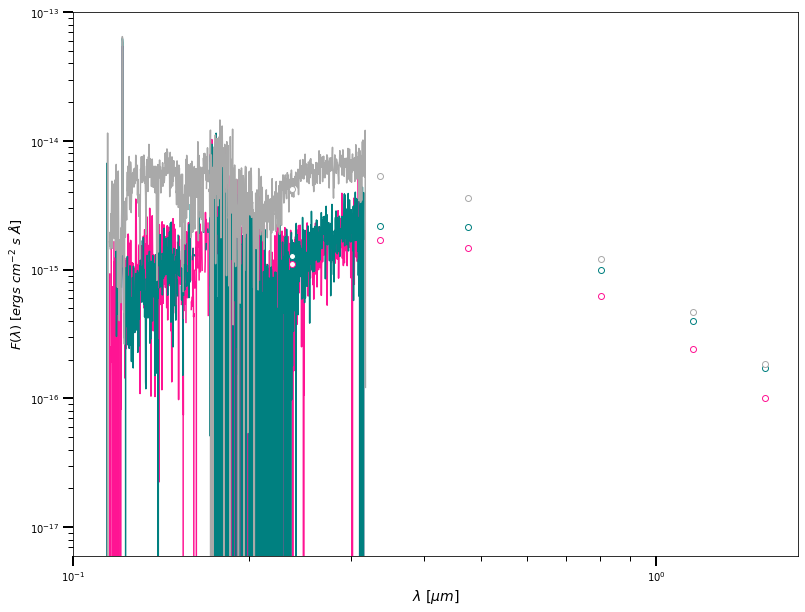

In [36]:
fig, ax = plt.subplots(figsize=(13, 10))
fontsize=10
colors = [#'r','gold','b','g',
          #'k','c','magenta','gray',
          #'lime','tomato','deepskyblue','purple',
          'deeppink', 'teal', 'darkgray']
plot_one=False
yoffset=20
yot='multiply'
for i in range(len(m31_list)):
    if plot_one:
        fstarname = f"{starname}.dat"
    else:
        starname = m31_list[i]
        print(starname)
        fstarname = f"{starname}.dat"

    reddened_star, band_names, data_names = get_red_star(fstarname, file_path)
#     print(i, fstarname)
    reddened_star.plot(ax, pcolor=colors[i], yoffset=yoffset, yoffset_type=yot)
    yoffset+=np.log(yoffset)
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(1e-16, 5e-14)
# ax.set_xlim(0.11, 0.33)
# ax.set_xlim(0.33, 1.5)
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=14)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")
plt.savefig(savefile_path + "spectra_v_" + starname + "_yoffset_" + str(yoffset) + ".png")

#Get reddened star data

In [6]:
reddened_star, band_names, data_names = get_red_star(fstarname, file_path)

band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])


Plot the spectrum (done above, not needed here)

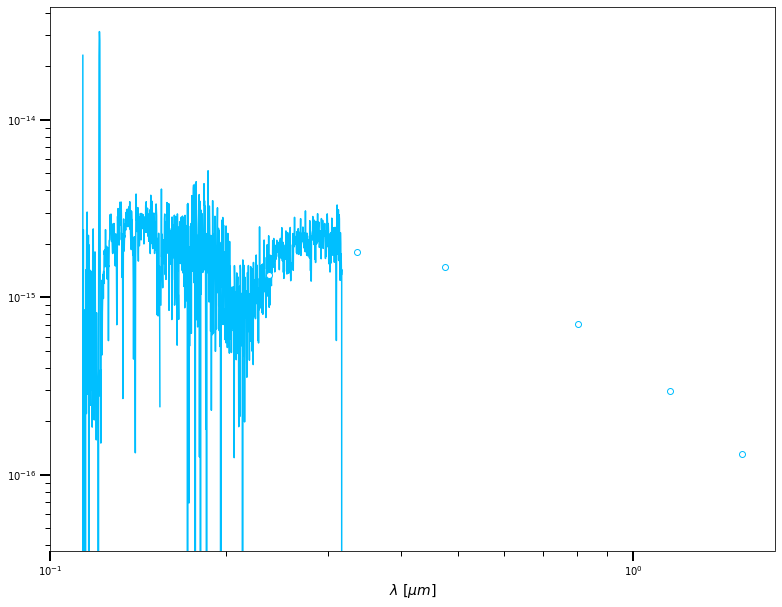

In [10]:
def plot_spectra(star, ax, color='deepskyblue', yoffset=10):
    """
    """

    reddened_star.plot(ax, pcolor=color, yoffset=yoffset)

Get the model data

In [73]:
importlib.reload(measure_extinction.modeldata)
importlib.reload(measure_extinction.stardata)

<module 'measure_extinction.stardata' from '/Users/pyanchulova/Documents/ext-science/measure_extinction/stardata.py'>

In [7]:
tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v10.dat".format(file_path))
# tlusty_models_fullpath = tlusty_models_fullpath[0:10]
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

# get the models with just the reddened star band data and spectra
modinfo = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
)

print("Done getting models")
# Model ranges for log(T), log(g) and log(Z)
print("log(Teff) range:", modinfo.temps_min, modinfo.temps_max)
print("log(g) range:", modinfo.gravs_min, modinfo.gravs_max)
print("log(Z) range:", modinfo.mets_min, modinfo.mets_max)

Done getting models
log(Teff) range: 4.176091259055681 4.740362689494244
log(g) range: 1.75 4.75
log(Z) range: -1.0 0.3010299956639812


#### Set up parameter grid ranges

In [85]:
# initial starting position needs to be customized for each star
# AzV23 sptype = B3Ia -> logTeff, logg
# SMC metallicity -> 0.2 (1/5 solar)
# Original params list
# params = [4.25, 3.09, 0.2, 0.75, 3.7, 2.5, 0.65, 0.26, 4.66, 0.86, 22.0, 19.0]
# pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]


# logtgrid = np.arange(4.17, 4.37, 0.1)
# logggrid = np.arange(2.75, 3.25, 0.5)
# logzgrid = np.arange(-0.3, 0.4, 0.1)
# avgrid = np.arange(0.4, 0.6, 0.1)
logtgrid = np.arange(4.17, 4.27, 0.1)
logggrid = np.arange(2.75, 3., 0.5)
logzgrid = np.arange(-0.3, 0.4, 0.1)
avgrid = np.arange(0.4, 0.6, 0.1)

# rvgrid = np.arange(3.1, 3.5, 0.2)
# c2grid = np.arange(1.9, 2.3, 0.2) # was (-0.5, 2, 0.4) 
# c3grid = np.arange(3, 5, 1)
rvgrid = np.arange(3.1, 3.5, 0.2)
c2grid = np.arange(1.3, 2.5, 0.4) # was (-0.5, 2, 0.4) 
c3grid = np.arange(2, 6, 1)
# c4grid = np.arange(-0.2, 2, 0.2)
# x0grid = np.arange(4.55, 4.7, 0.1)
x0grid = np.arange(4.55, 4.6, 0.1)
# gammagrid = np.arange(0., 1.5, 0.4)
gammagrid = np.arange(0.7, 0.9, 0.1)
# higalgrid = np.arange()
# himwgrid = np.arange()

# logzgrid = np.arange(modinfo.mets_min, modinfo.mets_max, 0.5)

# print("Size of T grid", len(logtgrid))
# print("Size of g grid", len(logggrid))
# print("Size of Av grid", len(avgrid))
print("log(T)", logtgrid)
print("log(g)", logggrid)
print("Av", avgrid)
print("Rv", rvgrid)
print("c2", c2grid)
print("c3", c3grid)
print("x0", x0grid)
print("gamma", gammagrid)

log(T) [4.17]
log(g) [2.75]
Av [0.4 0.5]
Rv [3.1 3.3]
c2 [1.3 1.7 2.1]
c3 [2 3 4 5]
x0 [4.55]
gamma [0.7 0.8 0.9]


#### Loop through params combo

In [44]:
importlib.reload(measure_extinction.utils.fit_model)
importlib.reload(measure_extinction)

<module 'measure_extinction' from '/Users/pyanchulova/Documents/ext-science/measure_extinction/__init__.py'>

In [86]:
outfolder = "narrow6/"
# Create weight arrays
weights = weightarrays(data_names, reddened_star)
n_comobs = len(logtgrid) * len(logggrid) * len(avgrid) * \
            len(c2grid) * len(c3grid) * len(x0grid) * \
            len(gammagrid) * len(rvgrid)
print("Generating %s combinations" % n_comobs)

# params_grid = []
for i in range(len(logtgrid)):
    for j in range(len(logggrid)):
        for k in range(len(avgrid)):
            for l in range(len(c2grid)):
                for m in range(len(c3grid)):
                    for n in range(len(x0grid)):
                        for o in range(len(gammagrid)):
                            for p in range(len(rvgrid)):
                                print("\nNew loop:\n log(T)=%s; log(g)=%s; Av=%s\n" % \
                                      (logtgrid[i], logggrid[j], avgrid[k]))
                                pnames, params, plimits, ppriors = setparams(logtgrid[i],
                                                                             logggrid[j],
                                                                             av=avgrid[k],
                                                                             rv=rvgrid[p],
                                                                             c2=c2grid[l], 
                                                                             c3=c3grid[m], 
                                                                             x0=x0grid[n],
                                                                             g=gammagrid[o])
                                fitinfo = package_fitinfo(pnames, plimits, weights, ppriors, velocity)

                                result = log_l_to_chi2(fitinfo, params, reddened_star, modinfo)
                                params, fit_params, params_best, pnames_extra = save_results(result, pnames)
                                modsed, \
                                ext_modsed, \
                                hi_ext_modsed, \
                                modsed_stardata, \
                                extdata, \
                                col_info = calc_ext_curve(fit_params, velocity, 
                                                          relband, reddened_star, 
                                                          starname, params)
                                print("params before plotting", params)
                                plot_spectra_2(hi_ext_modsed, reddened_star, modsed, ext_modsed, 
                                               modsed_stardata, folder=outfolder)
                                print('\n\n')

Generating 144 combinations

New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.3   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.3   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.3   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.3   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   1.7   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   1.7   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   1.7   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   1.7   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.1   2.1   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.1 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.1   2.1   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.4



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.4   3.3   2.1   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.4 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.4   3.3   2.1   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.3   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.3   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.3   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.3 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.3   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   1.7   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   1.7   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   1.7   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
1.7000000000000002 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   1.7   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   2.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   2.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   2.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   2.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   2.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
2.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   2.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   3.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   3.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   3.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   3.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   3.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
3.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   3.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   4.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   4.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   4.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   4.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   4.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
4.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   4.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   5.    0.26  4.55  0.7  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   5.    0.26  4.55  0.7  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   5.    0.26  4.55  0.8  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.7999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   5.    0.26  4.55  0.8  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.1   2.1   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.1 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.1   2.1   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/




New loop:
 log(T)=4.17; log(g)=2.75; Av=0.5



/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Maximum number of function evaluations has been exceeded.
in save_result. params =  [ 4.17  2.75  1.    0.5   3.3   2.1   5.    0.26  4.55  0.9  22.   19.  ]
4.17 # logT
2.75 # logg
1.0 # logZ
0.5 # Av
3.3000000000000003 # Rv
2.1000000000000005 # C2
5.0 # C3
0.26 # C4
4.55 # x0
0.8999999999999999 # gamma
22.0 # HI_gal
19.0 # HI_mw
[1.19811585e+08 1.27290777e+08 1.09499872e+08 ... 3.59472550e+07
 3.57569624e+07 3.56391771e+07] erg / (Angstrom cm2 s)
rel_b ACS_F475W
params before plotting [ 4.17  2.75  1.    0.5   3.3   2.1   5.    0.26  4.55  0.9  22.   19.  ]
Fig params are log(T)=4.17, log(g)=2.75, Av=1.0
making new dir /Users/pyanchulova/Documents/ext-science/figs/narrow6/





Test: try manual param values

In [29]:
# log(T), log(g), Av
# pnames, params, plimits, ppriors = setparams(3.8, logggrid[2], avgrid[1])

Setup the fit parameters

In [53]:
def setparams(logt=4.25, logg=3.09, logz=1., av=0.75, rv=3.7, c2=2.5, c3=0.65, c4=0.26, \
              x0=4.66, g=0.86 , hig=22.0, himw=19.0):
    """
    """
    # parameter names
    pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    # initial starting position
    #  **customize for each star**
    # AzV23 sptype = B3Ia -> logTeff, logg
    # SMC metallicity -> 0.2 (1/5 solar)
    # Original params list
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]
    # params = [4.25, 3.09, 0.2, 0.75, 3.7, 2.5, 0.65, 0.26, 4.66, 0.86, 22.0, 19.0]

    params = [logt, logg, logz, av, rv, c2, c3, c4, x0, g, hig, himw]

    # min/max allowed values for each parameter
    # some are based on the min/max of the stellar atmosphere grid
    plimits = [
            [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
            [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
            [modinfo.mets_min, modinfo.mets_max],    # log(Z)
            [0.0, 4.0],   # Av
            [2.0, 6.0],   # Rv
            [-0.1, 5.0],  # C2
            [0.0, 2.5],   # C3
            [0.0, 1.0],   # C4
            [4.5, 4.9],   # xo
            [0.6, 1.5],   # gamma
            [17.0, 24.0], # log(HI) internal to galaxy
            [17.0, 22.0], # log(HI) MW foreground
        ]

    # add Gaussian priors based on prior knowledge
    #  sptype -> log(Teff), log(g)
    #  galaxy metallicity -> log(Z)
    ppriors = {}
    ppriors["logT"] = (4.25, 0.1)
    ppriors["logg"] = (3.1, 0.1)
    ppriors["logZ"] = (0.2, 0.1)
    
#     print("Done setting parameters. log(T)=%s, log(g)=%s, av=%s" % (logt, logg, av))

    return pnames, params, plimits, ppriors    

Create the weight arrays based on the observed uncertainties

In [84]:
def weightarrays(data_names, reddened_star):
    """
    """
    # cropping info for weights
    #  bad regions are defined as those where we know the models do not work
    #  or the data is bad
    ex_regions = [
        [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
        [8.7, 10.0],  # bad data from STIS
        [3.55, 3.6],
        [3.80, 3.90],
        [4.15, 4.3],
        [6.4, 6.6],
        [7.1, 7.3],
        [7.45, 7.55],
        [7.65, 7.75],
        [7.9, 7.95],
        [8.05, 8.1],
    ] / u.micron

    weights = {}
    for cspec in data_names:
        weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
        gvals = reddened_star.data[cspec].npts > 0
#         weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value
        weights[cspec][gvals] = 2.0 / reddened_star.data[cspec].uncs[gvals].value

        x = 1.0 / reddened_star.data[cspec].waves
        for cexreg in ex_regions:
            weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

    # make the photometric bands have higher weight
#     weights["BAND"] *= 10000.0
    weights["BAND"] *= 20000.0
#     print("Done with weights based on uncertainties")
    return weights

Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [51]:
def package_fitinfo(pnames, plimits, weights, ppriors, velocity):
    """
    """
    fitinfo = FitInfo(
        pnames,
        plimits,
        weights,
        parameter_priors=ppriors,
        stellar_velocity=velocity,
    )
#     print("Done with packaging fit info")
    return fitinfo

In [51]:
# Was getting an error in fit_model.py where fitinfo is not recognized
# importlib.reload(measure_extinction.utils.fit_model)

In [15]:
# def nll(*args):
#     print("in nll")
#     # This is in lnprob

#     lnp = fitinfo.lnprior(params)
#     lnp_bignnum = -np.inf
#     if lnp == lnp_bignnum:
#         return -(lnp)
#     else:
#         return -(lnp + fitinfo.lnlike(*args))

# Previously the fn above was
def nll(*args):
    return -fitinfo.lnprob(*args)

# simple function to turn the log(likelihood) into the chisqr
#  requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
def log_l_to_chi2(fitinfo, params, reddened_star, modinfo):
    """
    """
    # run the fit
    result = op.minimize(
        nll, params, method="Nelder-Mead", args=(reddened_star, modinfo, fitinfo)
    )

    # check the fit output
    print(result["message"])
    return result

In [24]:
# save results
def save_results(result, pnames):
    """
    """
    params = result["x"]
    print("in save_result. params = ", params)
    fit_params = params
    params_best = params
    pnames_extra = pnames

    # print the best fit
    for k, val in enumerate(params_best):
        print("{} # {}".format(val, pnames_extra[k]))
        
    return params, fit_params, params_best, pnames_extra


In [56]:
#import measure_extinction
#importlib.reload(measure_extinction)
#importlib.reload(measure_extinction.extdata)

Calculate and save the extinction curve

In [55]:
def calc_ext_curve(fit_params, velocity, relband, reddened_star, starname, params):
    """
    """
    # intrinsic sed
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    # create an extincion curve and save it
    extdata = ExtData()
    print('rel_b', relband)
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    extdata.save(starname + "_ext_T%s.fits" % params[0], column_info=col_info)

#     print("Done with calculating and saving the ext curve")
    
    return modsed, ext_modsed, hi_ext_modsed, modsed_stardata, extdata, col_info

Plot the spectra

In [78]:
def plot_spectra_2(hi_ext_modsed, reddened_star, modesed, ext_modsed, \
                   modsed_stardata, folder='calc_spectra/'):
    """
    """
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 18
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(13, 10))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves,
        #        weights[cspec], 'k-')

        # Observations
        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data,
            "k" + ptype,
            label="data",
        )

        # print(reddened_star.data[cspec].waves)
        # print(modinfo.waves[cspec])

        # Intrinsic SED
        ax.plot(
            modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
        )
        
        # dust_extinguished sed
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec,
        )
        
        # hi abs sed
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
    ax.set_ylim(8e4 / norm_model, 2e9 / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    fig.tight_layout()
    plt.title(starname)
    
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]
    logt_round = np.around(params[0], decimals=3)
    av_round = np.around(params[3], decimals=3)
    rv_round = np.around(params[4], decimals=3)
    c2_round = np.around(params[5], decimals=3)
    c3_round = np.around(params[6], decimals=3)
    x0_round = np.around(params[8], decimals=3)
    g_round = np.around(params[9], decimals=3)
    print("Fig params are log(T)=%s, log(g)=%s, Av=%s" % (params[0], params[1], params[2]))
    if not os.path.isfile(savefile_path + folder):
        print("making new dir", (savefile_path + folder))
        os.system("mkdir " + savefile_path + folder)
    plt.savefig(savefile_path + folder + "_" + starname + "_T_" + str(logt_round)  + "_g_" + \
                str(params[1]) + "_Av_"  + str(av_round) + "_Rv_" + str(rv_round) + "_c2_" + str(c2_round) + "_c3_" + \
                str(c3_round) + "_x_" + str(x0_round) + "_gamma_" + str(g_round) + "_.png")
    plt.close()

Plot the extinction curve

True


/Users/pyanchulova/Documents/ext-science/measure_extinction/extdata.py:535: UserWarning: attempt to normalize a non-E(lambda-V) curve with A(V)
  "attempt to normalize a non-E(lambda-V) curve with A(V)", UserWarning


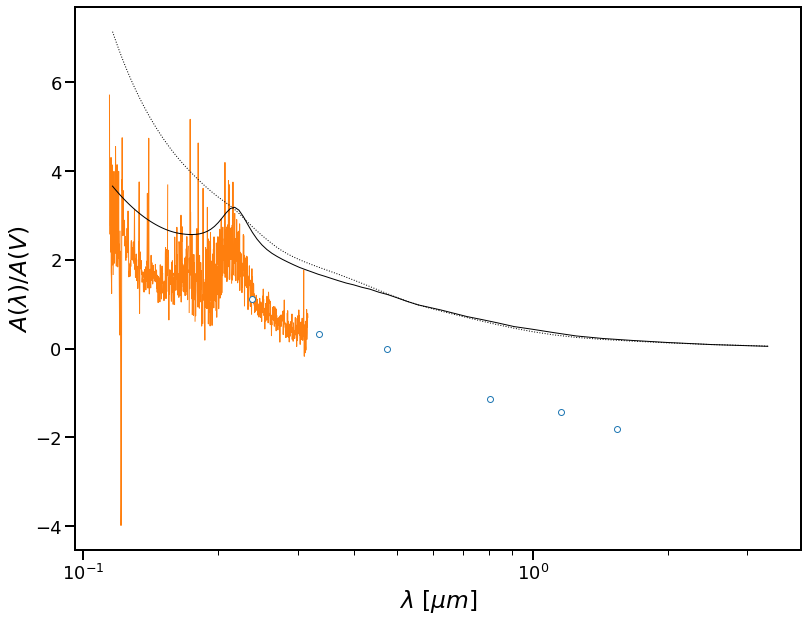

In [82]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
extdata.trans_elv_alav()

extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
#ax.set_ylim(0.0, 10.0)
ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")

f19_rv31 = F19(Rv=3.1)
ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")
plt.savefig(savefile_path + "extcurve_T" + str(params[0]) + "_" + starname + ".png")

Run emcee MCMC sampler to define uncertainties (bonus section)

In [41]:
p0 = params
ndim = len(p0)

#nwalkers = 2 * ndim
#nsteps = 50
#burn = 50

nwalkers = 100
nsteps = 50 #10,000
burn = 50

# setting up the walkers to start "near" the inital guess
p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

# setup the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo, fitinfo)
)

# burn in the walkers
pos, prob, state = sampler.run_mcmc(p, burn)

# rest the sampler
sampler.reset()

# do the full sampling
pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)

# create the samples variable for later use
samples = sampler.chain.reshape((-1, ndim))

# get the best fit values
pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
params_best = get_best_fit_params(sampler)
fit_params = params_best
print("best params")
print(params_best)

# get the 16, 50, and 84 percentiles
params_per = get_percentile_params(samples)

# save the best fit and p50 +/- uncs values to a file
# save as a single row table to provide a uniform format
#f = open(out_basename + "_fit_params.dat", "w")
#f.write("# best fit, p50, +unc, -unc\n")
for k, val in enumerate(params_per):
    print(
        "{} {} {} {} # {}".format(
            params_best[k], val[0], val[1], val[2], pnames_extra[k]
        )
    )
#    f.write(
#        "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#        )
#    )


ValueError: Probability function returned NaN

In [22]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save(starname + "_ext.fits", column_info=col_info)

[2.67192442e+08 3.54365022e+08 2.51821549e+08 ... 5.02542048e+07
 4.98852726e+07 4.94361270e+07] erg / (Angstrom cm2 s)
pband_name WFPC2_F170W
pband_name WFC3_F275W
type red_rel_band <class 'tuple'>
red_mag (17.643, 0.006, 'mag')
(19.018, 0.001, 'mag')
comp_mag[0] -41.30059929876516
comp_rel_band[0] -39.27395558953398
pband_name WFPC2_F255W
pband_name WFC3_F336W
type red_rel_band <class 'tuple'>
red_mag (17.782, 0.01, 'mag')
(19.018, 0.001, 'mag')
comp_mag[0] -40.529836254290274
comp_rel_band[0] -39.27395558953398
pband_name WFPC2_F336W
pband_name U
pband_name B
pband_name WFPC2_F439W
pband_name ACS_F475W
type red_rel_band <class 'tuple'>
red_mag (19.018, 0.001, 'mag')
(19.018, 0.001, 'mag')
comp_mag[0] -39.27395558953398
comp_rel_band[0] -39.27395558953398
pband_name WFC3_F475W
pband_name V
pband_name WFPC2_F555W
pband_name R
pband_name I
pband_name ACS_F814W
type red_rel_band <class 'tuple'>
red_mag (18.771, 0.001, 'mag')
(19.018, 0.001, 'mag')
comp_mag[0] -38.947094582484915
comp_re

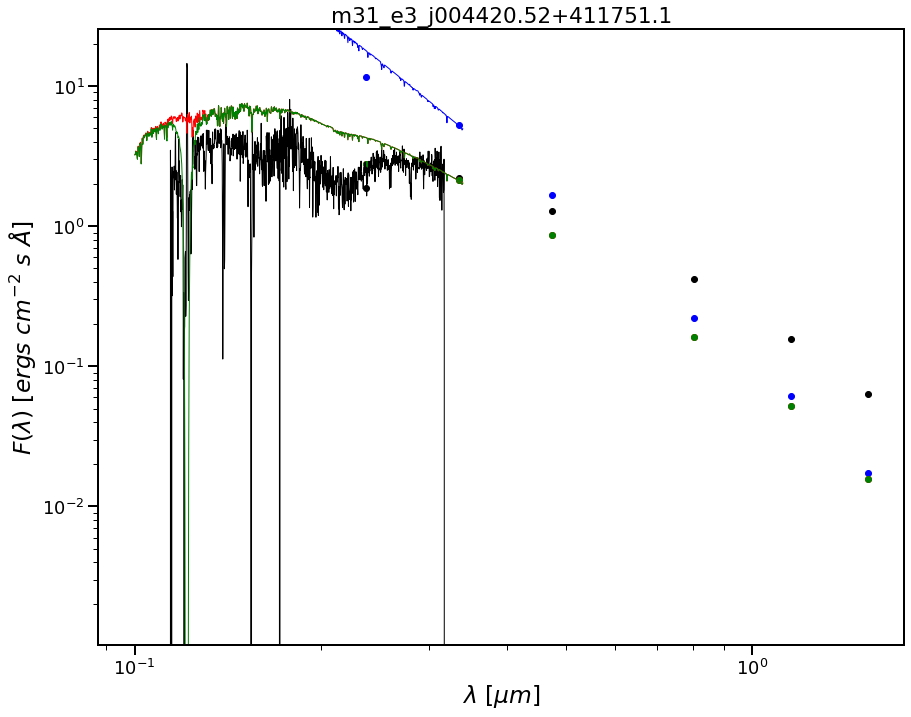

In [54]:
norm_model = np.average(hi_ext_modsed["BAND"])
norm_data = np.average(reddened_star.data["BAND"].fluxes)

# plotting setup for easier to read plots
fontsize = 18
font = {"size": fontsize}
mpl.rc("font", **font)
mpl.rc("lines", linewidth=1)
mpl.rc("axes", linewidth=2)
mpl.rc("xtick.major", width=2)
mpl.rc("xtick.minor", width=2)
mpl.rc("ytick.major", width=2)
mpl.rc("ytick.minor", width=2)

# setup the plot
fig, ax = plt.subplots(figsize=(13, 10))

# plot the bands and all spectra for this star
for cspec in modinfo.fluxes.keys():
    if cspec == "BAND":
        ptype = "o"
    else:
        ptype = "-"

    # ax.plot(reddened_star.data[cspec].waves,
    #        weights[cspec], 'k-')

    ax.plot(
        reddened_star.data[cspec].waves,
        reddened_star.data[cspec].fluxes / norm_data,
        "k" + ptype,
        label="data",
    )

    # print(reddened_star.data[cspec].waves)
    # print(modinfo.waves[cspec])

    ax.plot(
        modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
    )
    ax.plot(
        modinfo.waves[cspec],
        ext_modsed[cspec] / norm_model,
        "r" + ptype,
        label=cspec,
    )
    ax.plot(
        modinfo.waves[cspec],
        hi_ext_modsed[cspec] / norm_model,
        "g" + ptype,
        label=cspec,
    )

# finish configuring the plot
ax.set_ylim(8e4 / norm_model, 2e9 / norm_model)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# ax.legend()

# use the whitespace better
fig.tight_layout()
plt.title(starname)
plt.savefig(savefile_path + "extcurve_2_" + starname + ".png")

True


/Users/pyanchulova/Documents/ext-science/measure_extinction/extdata.py:534: UserWarning: attempt to normalize a non-E(lambda-V) curve with A(V)
  warnings.warn(


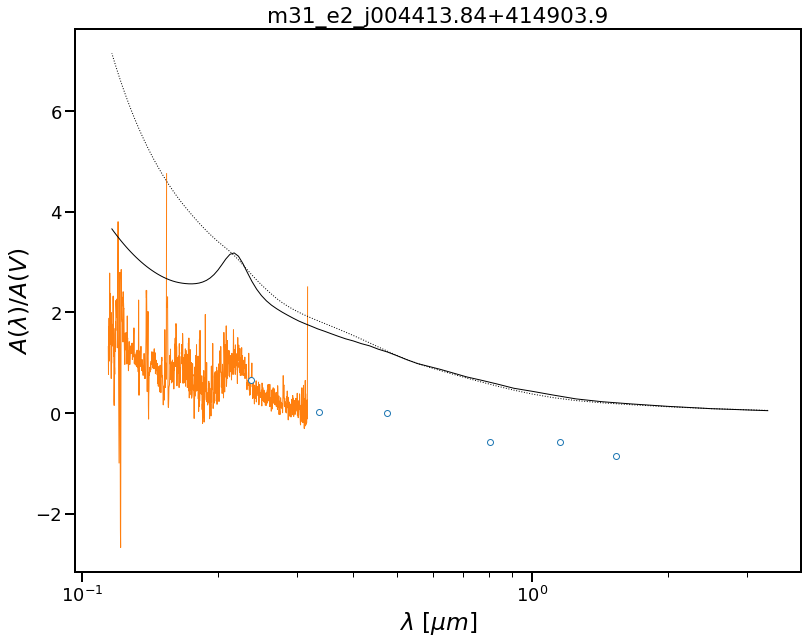

In [28]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
extdata.trans_elv_alav()

extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
#ax.set_ylim(0.0, 10.0)
ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")

f19_rv31 = F19(Rv=3.1)
ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")
plt.title(starname)
plt.savefig(savefile_path + "extcurve_2_" + starname + ".png")